In [1]:
import os
path_now=os.getcwd()
print(path_now)

os.chdir('D:')
path_current=os.getcwd()
print(path_current)

# write auto search funtion which to find the document need to improve in there~

import pandas as pd
df=pd.read_csv('D:/stock_prices.csv',header=None,names=(['price']))
df.head(5)

d:\Microsoft VS Code
d:\Microsoft VS Code


,price
0,10.000000
1,10.023333
2,10.006667
3,10.013333
4,10.046667


In [2]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values


price    0
dtype: int64

In [3]:
basic_stats = df.describe()
basic_stats

,price
count,3001.000000
mean,10.522229
std,0.269998
min,9.993333
25%,10.263333
50%,10.593333
75%,10.763333
max,11.030000


In [4]:
import numpy as np
df['Log_return']=np.log(df['price']/df['price'].shift(1))
df = df.dropna()

In [6]:
print(df.head()) # removed the first price since there is worthless
skewness = df['Log_return'].skew()
print(f"Skewness of log returns: {skewness}")

## Skewness is a measure of symmetry, or more precisely, the lack of symmetry.
#  A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

# Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution

       price  Log_return
1  10.023333    0.002331
2  10.006667   -0.001664
3  10.013333    0.000666
4  10.046667    0.003323
5  10.050000    0.000332
Skewness of log returns: -0.23405728220372318


the Skweness of log return is the -0.23 , so this is slightly nagetive skewed, ==
left tail is longer / fatter than the right part, 
more negative return -although the skewness value is not extremely large.

In [7]:
correlation = df['Log_return'].corr(df['Log_return'] ** 2)
print(f"Correlation between log returns and squared log returns: {correlation}")

# The leverage effect refers to the phenomenon where negative returns 
# tend to increase future volatility more than positive returns of the same magnitude



Correlation between log returns and squared log returns: -0.06642500626930359


the correlation between log returns and squared log returns is -0.066, which is slightly negative. This suggests a weak leverage effect

In [8]:
start_date = '2020-01-01'
date_range = pd.date_range(start=start_date, periods=len(df), freq='D')

df['Date'] = date_range
df.set_index('Date', inplace=True)
df.head(5)

,price,Log_return
Date,,
2020-01-01,10.023333,0.002331
2020-01-02,10.006667,-0.001664
2020-01-03,10.013333,0.000666
2020-01-04,10.046667,0.003323
2020-01-05,10.050000,0.000332


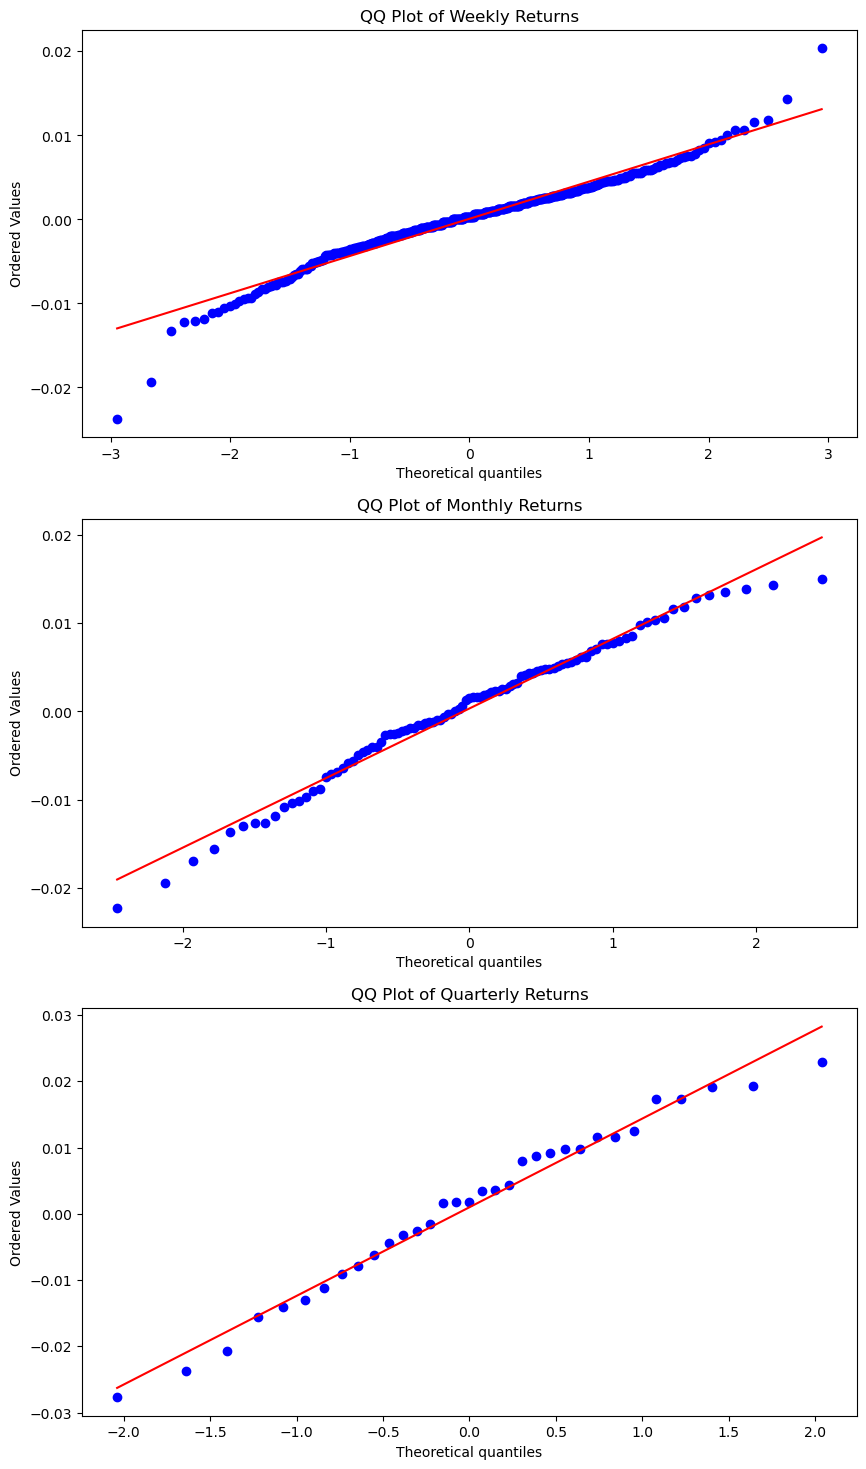

In [11]:
import scipy.stats as stats
import matplotlib.pyplot as plt
weekly_returns = df['Log_return'].resample('W').sum()
monthly_returns = df['Log_return'].resample('M').sum()
quarterly_returns = df['Log_return'].resample('Q').sum()
fig, ax = plt.subplots(3, 1, figsize=(10, 18))  # use Q-Q plot to compare distrubution 
stats.probplot(weekly_returns.dropna(), dist="norm", plot=ax[0])
ax[0].set_title('QQ Plot of Weekly Returns')

stats.probplot(monthly_returns.dropna(), dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot of Monthly Returns')

stats.probplot(quarterly_returns.dropna(), dist="norm", plot=ax[2])
ax[2].set_title('QQ Plot of Quarterly Returns')

plt.show()

The QQ plot for weekly returns shows that the points lie fairly close to the red line, the distribution of weekly returns is somewhat close to normal, but with potential deviations in the tails.

Kurtosis of log returns: 12.642149797942466


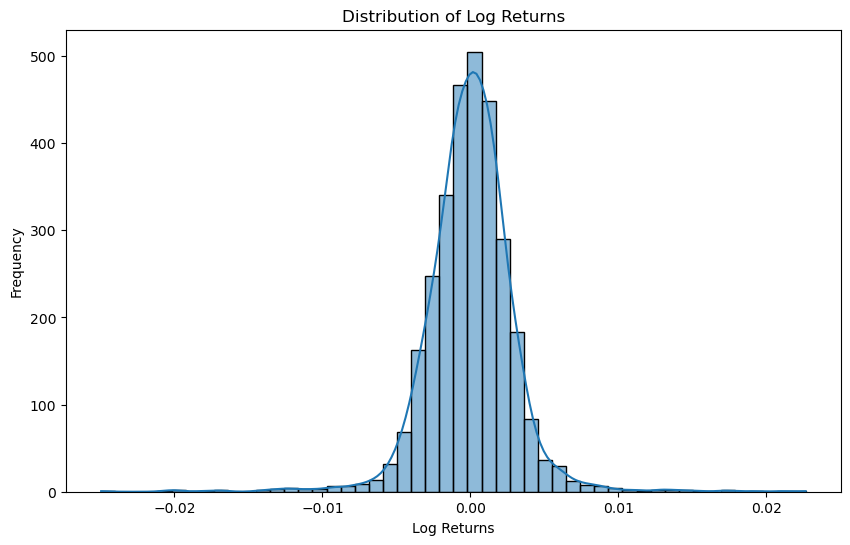

In [14]:
from scipy.stats import kurtosis
import seaborn as sns

kurt = kurtosis(df['Log_return'], fisher=False)
print(f"Kurtosis of log returns: {kurt}")

plt.figure(figsize=(10, 6))
sns.histplot(df['Log_return'], bins=50, kde=True)
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Log Returns')
plt.show()


 #bthe distribution of log returns is leptokurtic,

<Figure size 1000x600 with 0 Axes>

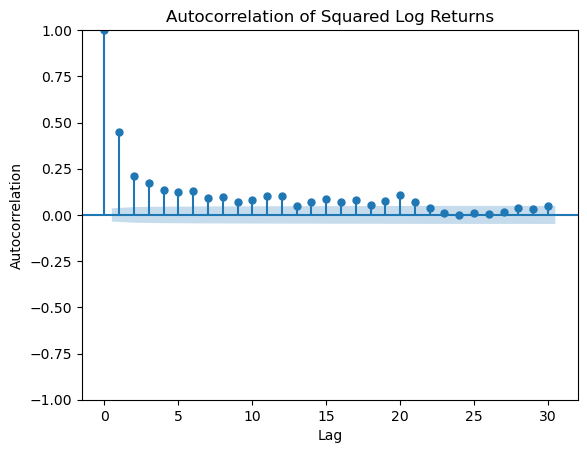

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_acf(df['Log_return'] ** 2, lags=30)
plt.title('Autocorrelation of Squared Log Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


d:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.901e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                13499.0
Distribution:                  Normal   AIC:                          -26990.0
Method:            Maximum Likelihood   BIC:                          -26965.9
                                        No. Observations:                 3000
Date:                Tue, Jul 02 2024   Df Residuals:                     2999
Time:                        14:47:30   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1009e-05  3.985e-05      0.276      0.782 

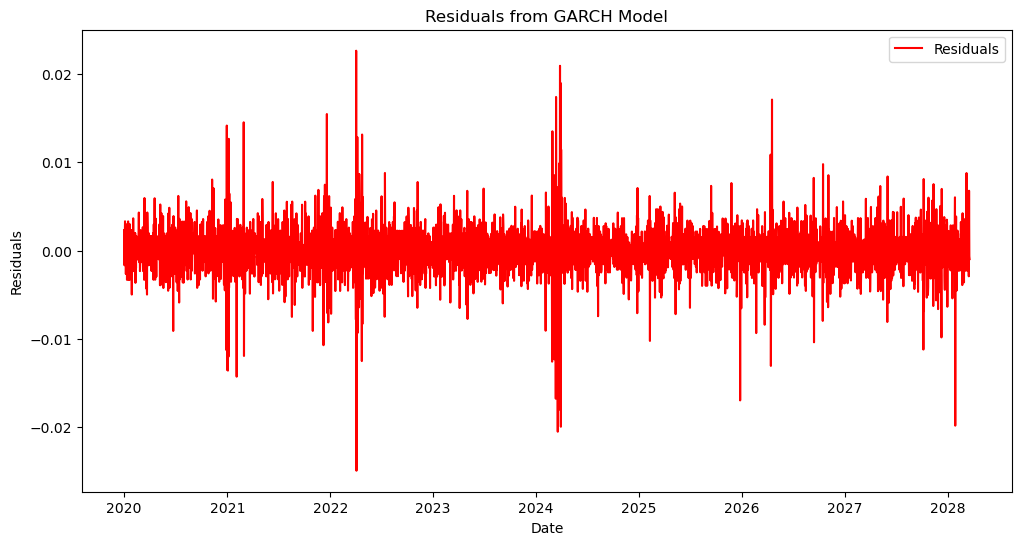

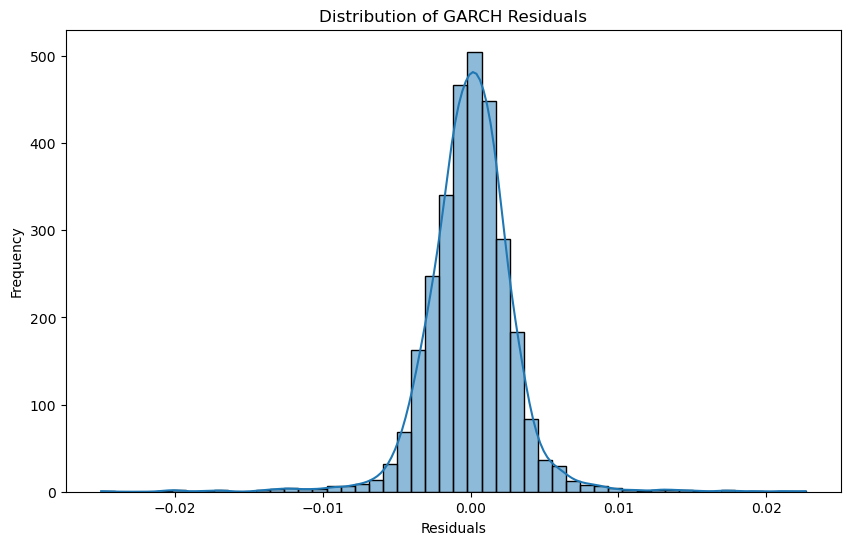

In [18]:
from arch import arch_model

# Fit a GARCH(1,1) model
model = arch_model(df['Log_return'], vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

print(garch_fit.summary())

# Get the residuals
residuals = garch_fit.resid

plt.figure(figsize=(12, 6))
plt.plot(df.index, residuals, label='Residuals', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals from GARCH Model')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of GARCH Residuals')
plt.show()


In [20]:
window_size = 30
df['Rolling_Mean'] = df['Log_return'].rolling(window=window_size).mean()
df['Rolling_Std'] = df['Log_return'].rolling(window=window_size).std()

risk_return_correlation = df['Rolling_Mean'].corr(df['Rolling_Std'])
print(f"Risk-return correlation: {risk_return_correlation}")


Risk-return correlation: -0.10198998610549048


Kurtosis of log returns: 12.642149797942466
Kurtosis of residuals: 12.642149797942466


<Figure size 1000x600 with 0 Axes>

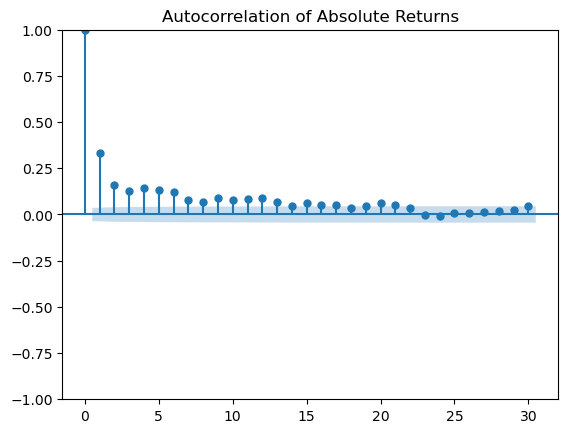

<Figure size 1000x600 with 0 Axes>

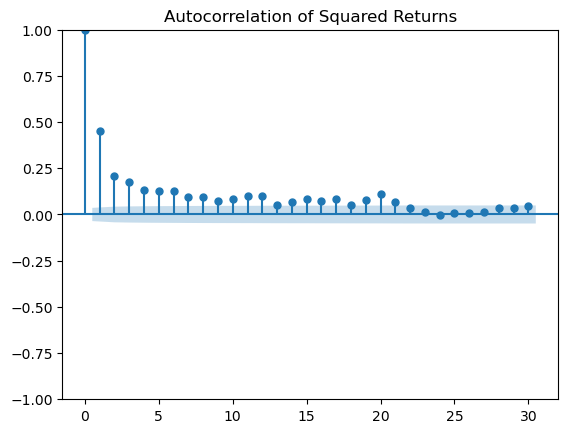

In [25]:
kurt_log_returns = kurtosis(df['Log_return'], fisher=False)
kurt_residuals = kurtosis(residuals, fisher=False)

print(f"Kurtosis of log returns: {kurt_log_returns}")
print(f"Kurtosis of residuals: {kurt_residuals}")

plt.figure(figsize=(10, 6))
plot_acf(df['Log_return'].abs(), lags=30, title='Autocorrelation of Absolute Returns')
plt.show()

plt.figure(figsize=(10, 6))
plot_acf(df['Log_return'] ** 2, lags=30, title='Autocorrelation of Squared Returns')
plt.show()



d:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.907e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\Chauncey Luo\AppData\Local\Temp\ipykernel_8160\2664555425.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

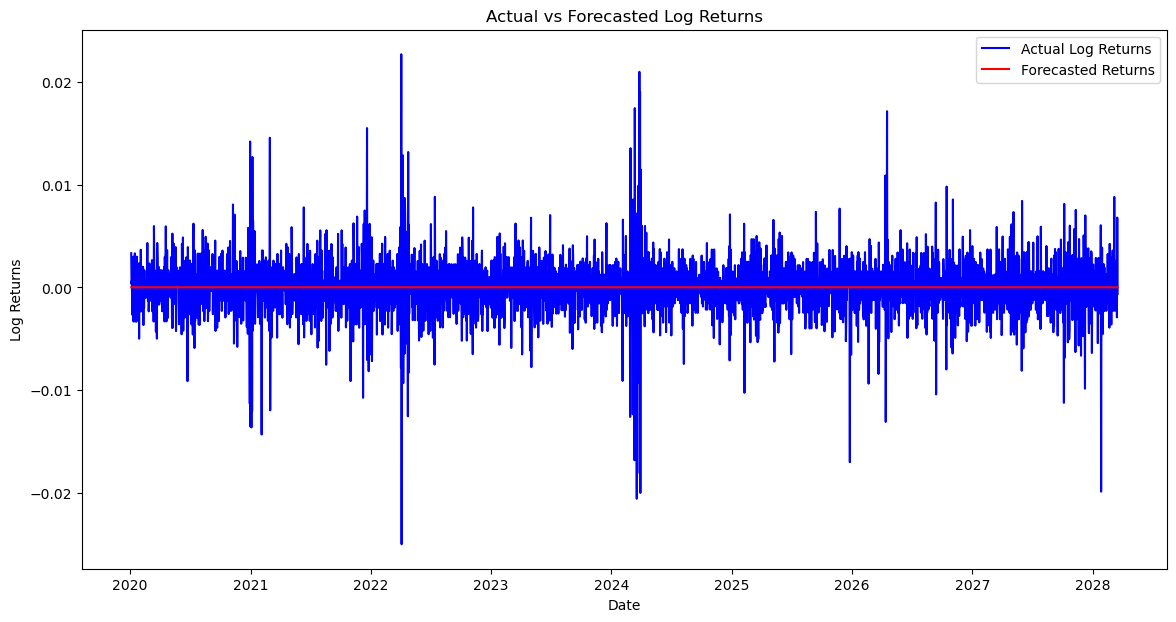

Mean Squared Error: 8.909743208707461e-06
Mean Absolute Error: 0.002056114704407318


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
model = arch_model(df['Log_return'], vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

forecasts = garch_fit.forecast(start=0, horizon=1, reindex=False)
df['Forecasted_Returns'] = forecasts.mean['h.1'].shift()

df = df.dropna(subset=['Forecasted_Returns'])

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Log_return'], label='Actual Log Returns', color='blue')
plt.plot(df.index, df['Forecasted_Returns'], label='Forecasted Returns', color='red')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Actual vs Forecasted Log Returns')
plt.legend()
plt.show()

actual = df['Log_return']
predicted = df['Forecasted_Returns']

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')